## Imports

In [1]:
%matplotlib inline

# Import functions
import timeit
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix
from scipy.interpolate import make_interp_spline

# Functions to play animations
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

# Circuit functions and gate definitions
import qctools
from gateset import *
from functions import *

# XY Hamiltonian Simulation

$$
w_p(\lambda, \gamma) = \sqrt{ (1 - \lambda \cos 2 \pi p )^2 + (\lambda~\gamma \sin 2 \pi p)^2 } 
\qquad\qquad
\theta_p(\lambda, \gamma) = \pi - \cos^{-1}\left( \frac{-1 + \lambda \cos 2 \pi p }{w_p(\lambda, \gamma)} \right)
$$

In [2]:
gamm = 1.
betas = [0., 0.125, 0.25, 0.5, 1., 2., 4., 8., 16., 32]

## 2 qubits

### Define parameters

In [3]:
lamb = 1.
N2 = 2.
k2 = [0,1]

p2 = [(x/N2) for x in k2]
w2 = [(1/lamb)*w(lamb, gamm, p2[jj]) for jj in range(len(p2))]
rw2 = list(reversed(w2) )

H_X2 = ((1/2)*lamb*(HXY_iso(c2, +1) + gamm*HXY_aniso(c2, +1)) + \
        (HXY_mag(c2) - (N2/2)*prod(I, I))) * (1./lamb)

### Define Hamiltonians

In [4]:
U_FT2 = qdot(prod(fSWAP),
             prod(Fou2(1/2)) )

U_Bog2 = csc_matrix((int(2**N2), int(2**N2) ), dtype=complex)

if lamb>1.0:
    U_Bog2 = qdot(prod(Bog2(theta(lamb, gamm, 0/2-1/2))),
                  prod(fSWAP),
                  prod(I, X))
    
if lamb<=1.0:
    U_Bog2 = qdot(prod(Bog2(theta(lamb, gamm, 0/2-1/2))), 
                  prod(fSWAP))

U_Dis2 = qdot(U_FT2, U_Bog2)

HD_P2 = qdot(U_FT2.getH(), H_X2, U_FT2)
HD_X2 = qdot(U_Bog2.getH(), U_FT2.getH(), H_X2, U_FT2, U_Bog2)
HD_E2 = HXY_diag(c2, w2) #* (1./lamb)

qf = qctools.CircuitTools(HD_X2)
qf.prettymatrix()
np.count_nonzero( np.around(HD_X2.diagonal() - HD_E2.diagonal(), 3) )

,0,1,2,3
0,-1.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0


0

### Define position/momentum/energy eigenstates

In [5]:
psi_X2 = spin_states(c2)
cp2 = fourier_transform(c2, p2)
psi_P2 = np.dot(psi_X2, spin_states(cp2))

#print(onequbit_modes(psi_P2) )
#print(onequbit_modes(U_FT2) )

In [6]:
val_E2 = HD_E2.diagonal()
psi_E2 = np.abs(psi_X2 )
ival_E2_ordered = np.argsort(val_E2 )

psiX1_E2 = reduce(np.dot, [U_Dis2.getH(), c2[0].getH(), psi_X2[:, 0]] )
psiX2_E2 = reduce(np.dot, [U_Dis2.getH(), c2[1].getH(), psi_X2[:, 0]] )

UD_E2 = [qexp(HD_E2, 0.25*x) for x in range(20)]
for x in UD_E2:
    x.eliminate_zeros()

### Define thermal states

In [7]:
psi_LP2 = build_LP(1., rw2)
psiC_LP2 = calc_LP(1., val_E2, psi_E2)

np.count_nonzero(np.around((psi_LP2[:,0] - psiC_LP2).todense(), 3) )

0

/home/q1park/qcircuits/functions.py:227: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[itp, ix] = expval.astype(float)
/home/q1park/qcircuits/functions.py:320: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[ib, ix] = entval.astype(float)
/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:838: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


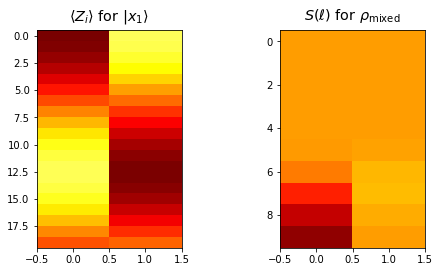

In [10]:
cols = [r'$\langle Z_i \rangle$ for $|x_1 \rangle$', 
        r'$S(\ell)$ for $\rho_{\rm mixed}$']

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(8, 4))

pad = 5 # in points

l8 = np.linspace(1,7, 7)
Struth = np.array([S_crit(0.5, 8, x, 0.5447) for x in l8])

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.025), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline');

for j, cell in enumerate(axes):
    if j==0:
        cell.imshow(scansig_time(UD_E2, psiX1_E2, U_Dis2, [Z] ).astype(float), 
                    cmap='hot', interpolation='nearest', vmin = -1.5, vmax = 1.5, aspect = 0.3/2)
 
    if j==1:
        cell.imshow(scanent_temp(betas, rw2, U_Dis2, 'mixed' ).astype(float), 
           cmap='hot', interpolation='nearest', vmin = -3, vmax = 2, aspect = 0.3)
plt.show();

## 4 qubits

### Define parameters

In [8]:
N4 = 4.

k4, k4S = [0,2,-1,1], [2,-1,0,1]
p4, p4S = [(x/N4) for x in k4], [(x/N4) for x in k4S]
w4 = [(1/lamb)*w(lamb, gamm, p4[jj]) for jj in range(len(p4))]
rw4 = list(reversed(w4) )
w4S = [w(lamb, gamm, p4S[jj]) for jj in range(len(p4S))]

H_X4 = ((1/2)*lamb*(HXY_iso(c4, +1) + gamm*HXY_aniso(c4, +1)) + \
        (HXY_mag(c4) - (N4/2)*prod(I, I, I, I))) * (1./lamb)

### Define Hamiltonians

In [9]:
U_RG4 = qdot(prod(I, I, fSWAP),
             prod(I, fSWAP, I))

U_FT4 = qdot(prod(I, fSWAP, I),
             prod(Fou2(1/4), I, I),
             prod(I, I, Fou2(0)),
             prod(I, fSWAP, I),
             prod(Fou2(0), I, I),
             prod(I, I, Fou2(0)) )

U_Bog4 = csc_matrix((int(2**N4), int(2**N4) ), dtype=complex)

if lamb>1.0:
    U_Bog4 = qdot(prod(Bog2(theta(lamb, gamm, 1/4-1/2)), 
                       Bog2(theta(lamb, gamm, 0/4-1/2))),
                  prod(fSWAP, fSWAP),
                  prod(I, I, I, X))
    
if lamb<=1.0:
    U_Bog4 = qdot(prod(Bog2(theta(lamb, gamm, 1/4-1/2)), 
                       Bog2(theta(lamb, gamm, 0/4-1/2))),
                  prod(fSWAP, fSWAP))

U_Dis4 = qdot(U_FT4, U_Bog4)

HD_E4 = HXY_diag(c4, w4) #* (1./lamb)
HD_P4 = qdot(U_FT4.getH(), H_X4, U_FT4)
HD_X4 = qdot(U_Bog4.getH(), U_FT4.getH(), H_X4, U_FT4, U_Bog4)

qf = qctools.CircuitTools(HD_X4)
#qf.prettymatrix()
qf.check_nnz()

np.count_nonzero( np.around(HD_X4.diagonal() - HD_E4.diagonal(), 3) )

16

0

### Define position/momentum/energy states

In [10]:
psi_X4 = spin_states(c4)
cp4 = fourier_transform(c4, p4)
psi_P4 = np.dot(psi_X4, spin_states(cp4))

#print(onequbit_modes(psi_P4) )
#print(onequbit_modes(U_FT4 ) )

In [11]:
val_E4 = HD_E4.diagonal()
psi_E4 = np.abs(psi_X4 )
ival_E4_ordered = np.argsort(val_E4 )

psiX1_E4 = reduce(np.dot, [U_Dis4.getH(), c4[0].getH(), psi_X4[:, 0]] )
psiX2_E4 = reduce(np.dot, [U_Dis4.getH(), c4[1].getH(), psi_X4[:, 0]] )
psiX3_E4 = reduce(np.dot, [U_Dis4.getH(), c4[2].getH(), psi_X4[:, 0]] )
psiX4_E4 = reduce(np.dot, [U_Dis4.getH(), c4[3].getH(), psi_X4[:, 0]] )

psiX_E4 = [psiX1_E4, psiX2_E4, psiX3_E4, psiX4_E4]

UD_E4 = [qexp(HD_E4, 0.25*x) for x in range(20)]
for x in UD_E4:
    x.eliminate_zeros()

rhoE0_E4 = np.dot(psi_E4[:, 0],psi_E4[:, 0].getH())
rhoE0_X4 = reduce(np.dot, [U_Dis4, UD_E4[0], rhoE0_E4, UD_E4[0].getH(), U_Dis4.getH()] )

/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### Define thermal states

In [12]:
psi_LP4 = build_LP(1., rw4)
psiC_LP4 = calc_LP(1, val_E4, psi_E4)

np.count_nonzero(np.around((psi_LP4[:,0] - psiC_LP4).todense(), 3) )

0

In [13]:
psi_TFD4 = build_TFD(1., rw2)
psiC_TFD4 = calc_TFD(1., val_E2, psi_E2)

np.count_nonzero(np.around((psi_TFD4[:,0] - psiC_TFD4).todense(), 3) )

rhoTFD_E4 = np.dot(psi_TFD4, psi_TFD4.getH())

0

### Plots

In [33]:
rhoX1_E2_RG = reduce(np.dot, [U_Bog2.getH(),
                              pTraceM(reduce(np.dot, [U_RG4,
                                                      U_Bog4, 
                                                      np.dot(psiX1_E4, psiX1_E4.getH()),
                                                      U_Bog4.getH(),
                                                      U_RG4.getH() ] ), [3,4] ),
                              U_Bog2] )
rhoX2_E2_RG = reduce(np.dot, [U_Bog2.getH(),
                              pTraceM(reduce(np.dot, [U_RG4,
                                                      U_Bog4, 
                                                      np.dot(psiX2_E4, psiX2_E4.getH()),
                                                      U_Bog4.getH(),
                                                      U_RG4.getH() ] ), [3,4] ),
                              U_Bog2] )

rhoX3_E2_RG = reduce(np.dot, [U_Bog2.getH(),
                              pTraceM(reduce(np.dot, [U_RG4,
                                                      U_Bog4, 
                                                      np.dot(psiX3_E4, psiX3_E4.getH()),
                                                      U_Bog4.getH(),
                                                      U_RG4.getH() ] ), [3,4] ),
                              U_Bog2] )

rhoX4_E2_RG = reduce(np.dot, [U_Bog2.getH(),
                              pTraceM(reduce(np.dot, [U_RG4,
                                                      U_Bog4, 
                                                      np.dot(psiX4_E4, psiX4_E4.getH()),
                                                      U_Bog4.getH(),
                                                      U_RG4.getH() ] ), [3,4] ),
                              U_Bog2] )

rhoX_E2_RG = [rhoX1_E2_RG, rhoX2_E2_RG, rhoX3_E2_RG, rhoX4_E2_RG]

/home/q1park/qcircuits/functions.py:227: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[itp, ix] = expval.astype(float)


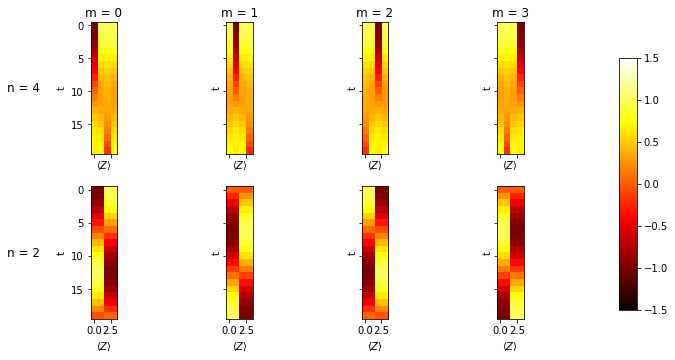

In [16]:
cols = ['m = {}'.format(col) for col in range(4)]
rows = ['n = {}'.format(row) for row in ['4  ', '2  ']]

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10, 5))

plt.setp(axes.flat, xlabel=r'$\langle Z \rangle$', ylabel='t')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline');

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center');

for i, row in enumerate(axes):
    for j, cell in enumerate(row):
        if i==0:
            cell.imshow(scansig_time(UD_E4, psiX_E4[j], U_Dis4, [Z] ), 
                        cmap='hot', interpolation='nearest', vmin = -1.5, vmax = 1.5 )
        if i==1:
            cell.imshow(-1+2*scansig_time(UD_E2, rhoX_E2_RG[j], U_Dis2, [Z], wider=True ), 
                        cmap='hot', interpolation='nearest', vmin = -1.5, vmax = 1.5 )
            legender = cell.imshow(-1+2*scansig_time(UD_E2, rhoX_E2_RG[j], U_Dis2, [Z], wider=True ),
                                   cmap='hot', interpolation='nearest', vmin = -1.5, vmax = 1.5 )
            
fig.tight_layout();
fig.subplots_adjust(left=0.15, top=0.95);
#fig.colorbar(legender, ax=axes.ravel().tolist())

cbar_ax = fig.add_axes([1., 0.15, 0.025, 0.7])
fig.colorbar(legender, cax=cbar_ax)

plt.show();

/home/q1park/qcircuits/functions.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[ib, ix] = expval.astype(float)
/home/q1park/qcircuits/functions.py:320: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[ib, ix] = entval.astype(float)
/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:829: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:838: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


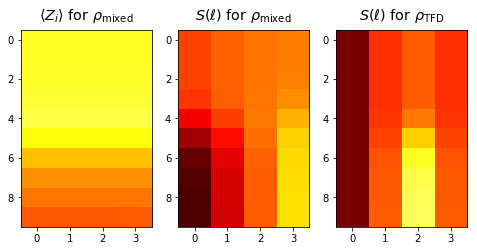

In [17]:
cols = [r'$\langle Z_i \rangle$ for $\rho_{\rm mixed}$', 
        r'$S(\ell)$ for $\rho_{\rm mixed}$', 
        r'$S(\ell)$ for $\rho_{\rm TFD}$']

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 4))

pad = 5 # in points

l8 = np.linspace(1,7, 7)
Struth = np.array([S_crit(0.5, 8, x, 0.5447) for x in l8])

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.025), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline');

for j, cell in enumerate(axes):
    if j==0:
        cell.imshow(scansig_temp(betas, rw4, U_Dis4, [Z], 'mixed' ).astype(float), 
                    cmap='hot', interpolation='nearest', vmin = -1.5, vmax = 1.5, aspect = 0.3*2)
 
    if j==1:
        cell.imshow(scanent_temp(betas, rw4, U_Dis4, 'mixed' ).astype(float), 
                    cmap='hot', interpolation='nearest', vmin = -10, vmax = 10, aspect = 0.3*2)
    
    if j==2:
        cell.imshow(scanent_temp(betas, rw2, prod(U_Dis2, U_Dis2), 'double' ).astype(float), 
                    cmap='hot', interpolation='nearest', vmin = -0.5, vmax = 2.5, aspect = 0.3*2)
plt.show();

### n=8 Circuit

### Define parameters

In [14]:
lamb = 1.
N8 = 8

#k8 = [0,4,-2,2,-1,1,-3,3]
k8 = [0,4,-2,2,-3,3,-1,1]
p8 = [(x/N8) for x in k8]
w8 = [(1/lamb)*w(lamb, gamm, p8[jj]) for jj in range(len(p8))]
rw8 = list(reversed(w8) )

H_X8 = ((1/2)*lamb*(HXY_iso(c8, +1) + gamm*HXY_aniso(c8, +1)) + \
       (HXY_mag(c8) - (N8/2)*prod(I, I, I, I, I, I, I, I))) * (1./lamb)

### Define Hamiltonians

In [15]:
U1_RG8 = qdot(prod(I, fSWAP, I, I, I, I, I),
              prod(fSWAP, I, I, I, I, I, I),
              prod(I, fSWAP, I, I, I, I, I))

U2_RG8 = qdot(prod(I, fSWAP, I, I, I, I, I),
              prod(I, I, fSWAP, I, I, I, I),
              prod(I, fSWAP, I, I, I, I, I))

In [16]:
U_FT8_3 = qdot(prod(I, I, I, fSWAP, I, I, I),
               prod(I, I, fSWAP, fSWAP, I, I),
               prod(I, fSWAP, fSWAP, fSWAP, I),
               prod(Fou2(3/8), Fou2(2/8), Fou2(1/8), Fou2(0/8)),
               prod(I, fSWAP, fSWAP, fSWAP, I),
               prod(I, I, fSWAP, fSWAP, I, I),
               prod(I, I, I, fSWAP, I, I, I) )

U_FT8_2 = qdot(prod(I, I, I, I, I, fSWAP, I),
               prod(I, I, I, I, Fou2(2/8), I, I),
               prod(I, I, I, I, I, I, Fou2(0)),
               prod(I, I, I, I, I, fSWAP, I),
               prod(I, I, I, I, Fou2(0), I, I),
               prod(I, I, I, I, I, I, Fou2(0)))

U_FT8_1 = qdot(prod(I, fSWAP, I, I, I, I, I),
               prod(Fou2(2/8), I, I, I, I, I, I),
               prod(I, I, Fou2(0), I, I, I, I),
               prod(I, fSWAP, I, I, I, I, I),
               prod(Fou2(0), I, I, I, I, I, I),
               prod(I, I, Fou2(0), I, I, I, I) )

#U_FT8_1.eliminate_zeros()
#U_FT8_2.eliminate_zeros()
#U_FT8_3.eliminate_zeros()

U_FT8 = qdot(U_FT8_3, U_FT8_2, U_FT8_1, U1_RG8)

#onequbit_modes(np.around(U_FT8, 3))[:, 0:4]
#onequbit_modes(np.around(U_FT8, 3))[:, 4:8]

#onequbit_modes(np.around(U_FT8, 3))[0:4, :]
#onequbit_modes(np.around(U_FT8, 3))[4:8, :]

In [17]:
U_Bog8 = csc_matrix((int(2**N8), int(2**N8) ), dtype=complex)

if lamb>1.0:
    U_Bog8 = qdot(prod(Bog2(theta(lamb, gamm, 3/8-1/2)),
                       Bog2(theta(lamb, gamm, 1/8-1/2)),
                       Bog2(theta(lamb, gamm, 2/8-1/2)),
                       Bog2(theta(lamb, gamm, 0/8-1/2))),
                  prod(fSWAP, fSWAP, fSWAP, fSWAP),
                  prod(I, I, I, I, I, I, I, X))
    
if lamb<=1.0:
    U_Bog8 = qdot(prod(Bog2(theta(lamb, gamm, 3/8-1/2)),
                       Bog2(theta(lamb, gamm, 1/8-1/2)),
                       Bog2(theta(lamb, gamm, 2/8-1/2)),
                       Bog2(theta(lamb, gamm, 0/8-1/2))),
                  prod(fSWAP, fSWAP, fSWAP, fSWAP))

U_Dis8 = qdot(U_FT8, U_Bog8)

HD_E8 = HXY_diag(c8, w8) #* (1./lamb)
HD_P8 = qdot(U_FT8.getH(), H_X8, U_FT8)
HD_X8 = qdot(U_Bog8.getH(), U_FT8.getH(), H_X8, U_FT8, U_Bog8)

qf = qctools.CircuitTools(HD_X8)
#qf.prettymatrix()
qf.check_nnz()
np.count_nonzero( np.around(HD_X8.diagonal() - HD_E8.diagonal(), 3) )

256

0

### Define position/momentum/energy states

In [18]:
psi_X8 = spin_states(c8)
cc8 = fourier_transform(c8, p8)
psi_P8 = np.dot(psi_X8, spin_states(cc8))

#onequbit_modes(np.around(psi_P8,3))[:, 0:4]
#onequbit_modes(np.around(psi_P8,3))[:, 4:8]

In [19]:
val_E8 = HD_E8.diagonal()
psi_E8 = np.abs(psi_X8 )
ival_E8_ordered = np.argsort(val_E8 )

psiX1_E8 = reduce(np.dot, [U_Dis8.getH(), c8[0].getH(), psi_X8[:, 0]] )
psiX2_E8 = reduce(np.dot, [U_Dis8.getH(), c8[1].getH(), psi_X8[:, 0]] )
psiX3_E8 = reduce(np.dot, [U_Dis8.getH(), c8[2].getH(), psi_X8[:, 0]] )
psiX4_E8 = reduce(np.dot, [U_Dis8.getH(), c8[3].getH(), psi_X8[:, 0]] )
psiX5_E8 = reduce(np.dot, [U_Dis8.getH(), c8[4].getH(), psi_X8[:, 0]] )
psiX6_E8 = reduce(np.dot, [U_Dis8.getH(), c8[5].getH(), psi_X8[:, 0]] )
psiX7_E8 = reduce(np.dot, [U_Dis8.getH(), c8[6].getH(), psi_X8[:, 0]] )
psiX8_E8 = reduce(np.dot, [U_Dis8.getH(), c8[7].getH(), psi_X8[:, 0]] )

psiX_E8 = [psiX1_E8, psiX2_E8, psiX3_E8, psiX4_E8,
           psiX5_E8, psiX6_E8, psiX7_E8, psiX8_E8]

UD_E8 = [qexp(HD_E8, 0.25*x) for x in range(20)]
for x in UD_E8:
    x.eliminate_zeros()

/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### Define thermal states

In [20]:
psi_LP8 = build_LP(1., rw8)
psiC_LP8 = calc_LP(1, val_E8, psi_E8)

np.count_nonzero(np.around((psi_LP8[:,0] - psiC_LP8).todense(), 3) )

0

In [21]:
psi_TFD8 = build_TFD(1., rw4)
psiC_TFD8 = calc_TFD(1., val_E4, psi_E4)

np.count_nonzero(np.around((psi_TFD8[:,0] - psiC_TFD8).todense(), 3) )

0

### Plots I

In [93]:
rhoE0_E8_l = np.dot(psi_E8[:, 0],psi_E8[:, 0].getH())
rhoTFD_E8_l = np.dot(psi_TFD8[:,0],psi_TFD8[:,0].getH())

In [1]:
#S8plot_l001 = scanent_time(UD_E8[:1], rhoE0_E8_l, U_Dis8 )
#S8plotTFD_l001a = scanent_temp(betas[4:5], rw4, U_Dis8, 'double' ) 
#S8plotTFD_l001b = scanent_temp(betas[4:5], rw4, prod(U_Dis4, U_Dis4), 'double' ) 

In [2]:
#S8plot_l005 = scanent_time(UD_E8[:1], rhoE0_E8_l, U_Dis8 )
#S8plotTFD_l005a = scanent_temp(betas[4:5], rw4, U_Dis8, 'double' ) 
#S8plotTFD_l005b = scanent_temp(betas[4:5], rw4, prod(U_Dis4, U_Dis4), 'double' ) 

In [94]:
S8plot_l010 = scanent_time(UD_E8[:1], rhoE0_E8_l, U_Dis8 )
S8plotTFD_l010a = scanent_temp(betas[4:5], rw4, U_Dis8, 'double' ) 
S8plotTFD_l010b = scanent_temp(betas[4:5], rw4, prod(U_Dis4, U_Dis4), 'double' ) 

/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:829: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
/home/q1park/qcircuits/functions.py:346: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[itp, ix] = entval.astype(float)
/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:838: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


logm result may be inaccurate, approximate err = 2.418950804822236e-10


/home/q1park/qcircuits/functions.py:320: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[ib, ix] = entval.astype(float)


logm result may be inaccurate, approximate err = 1.806746124001506e-07


In [3]:
#S8plot_l100 = scanent_time(UD_E8[:1], rhoE0_E8_l, U_Dis8 )
#S8plotTFD_l100a = scanent_temp(betas[4:5], rw4, U_Dis8, 'double' ) 
#S8plotTFD_l100b = scanent_temp(betas[4:5], rw4, prod(U_Dis4, U_Dis4), 'double' ) 

In [ ]:
#rhoE0_E8 = np.dot(psi_E8[:, 0],psi_E8[:, 0].getH())
#S8plot = scanent_time(UD_E8[:1], rhoE0_E8, U_Dis8 )

#rhoTFD_E8 = np.dot(psi_TFD8[:,0],psi_TFD8[:,0].getH())
#S8plotTFD = scanent_temp(betas[4:5], rw4, prod(U_Dis4, U_Dis4), 'double' ) 

Text(0, 5, 'Ground State $| E_0 \\rangle$')

Text(0, 5, 'Thermo-field Double $| TFD \\rangle$')

Text(0, 5, 'subregion $(0, x_i)$')

Text(0, 5, 'subregion $(0, x_i)$')

Text(-9.0, 0, 'Entanglement Entropy   $S(0, x_i)$')

/home/q1park/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


Text(0.5, 1.005, '$\\beta = 1/T = 1$')

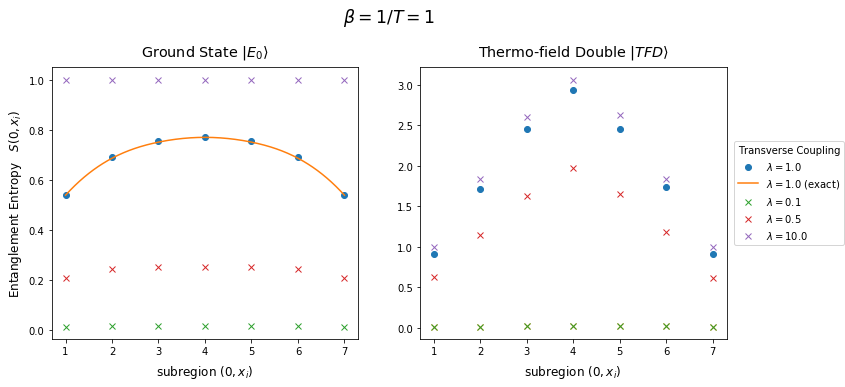

In [96]:
cols = [r'Ground State $| E_0 \rangle$', 
        r'Thermo-field Double $| TFD \rangle$']
rows = ['Exact']

clabels = [r'subregion $(0, x_i)$']*len(cols)
rlabels = [r'Entanglement Entropy   $S(0, x_i)$']*len(rows)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(12.5, 5))

#plt.setp(axes.flat, xlabel=r'$\langle Z \rangle$', ylabel='t')

pad = 5 # in points

l8 = np.linspace(1,7, 7)
Struth = np.array([S_crit(0.5, 8, x, 0.5447) for x in l8])

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.025), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline');
    
for ax, clabel in zip(axes, clabels):
    ax.annotate(clabel, xy=(0.5, -0.15), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline');

axes[0].annotate(rlabels[0], xy=(0., 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=axes[0].yaxis.label, textcoords='offset points',
                size='large', ha='center', va='center', rotation=90);

for j, cell in enumerate(axes):
    if j==0:
        leg1 = cell.plot(l8, S8plot_l010.reshape(8,)[1:], "o")
        l_smooth = np.linspace(l8.min(),l8.max(),300) #300 represents number of points to make between T.min and T.max
        spl = make_interp_spline(l8, Struth, k=3) #BSpline object
        S_smooth = spl(l_smooth)
        leg2 = cell.plot(l_smooth,S_smooth)
        
        leg3 = cell.plot(l8, S8plot_l001.reshape(8,)[1:], "x")
        leg4 = cell.plot(l8, S8plot_l005.reshape(8,)[1:], "x")
        leg5 = cell.plot(l8, S8plot_l100.reshape(8,)[1:], "x")
        
        
    if j==1:
        cell.plot(l8, S8plotTFD_l010a.reshape(8,)[1:], "o")
        cell.plot(l8, S8plotTFD_l001a.reshape(8,)[1:], "x")
        cell.plot(l8, S8plotTFD_l001a.reshape(8,)[1:], "x")
        cell.plot(l8, S8plotTFD_l005a.reshape(8,)[1:], "x")
        cell.plot(l8, S8plotTFD_l100a.reshape(8,)[1:], "x")

line_labels = [r"$\lambda = 1.0$", r"$\lambda = 1.0$ (exact)", 
               r"$\lambda = 0.1$", r"$\lambda = 0.5$", 
               r"$\lambda = 10.0$"]
        
fig.legend([leg1, leg2, leg3, leg4, leg5],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Transverse Coupling"  # Title for the legend
           )
fig.text(0.5, 1.005, r'$\beta = 1/T = 1$', ha='center', size='xx-large')
plt.subplots_adjust(right=0.875)

Text(0, 5, 'Ground State $| E_0 \\rangle$')

Text(0, 5, 'Thermo-field Double $| TFD \\rangle$')

Text(0, 5, 'subregion $(0, x_i)$')

Text(0, 5, 'subregion $(0, x_i)$')

Text(-9.0, 0, 'Entanglement Entropy   $S(0, x_i)$')

/home/q1park/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


Text(0.5, 1.005, '$\\beta = 1/T = 1$')

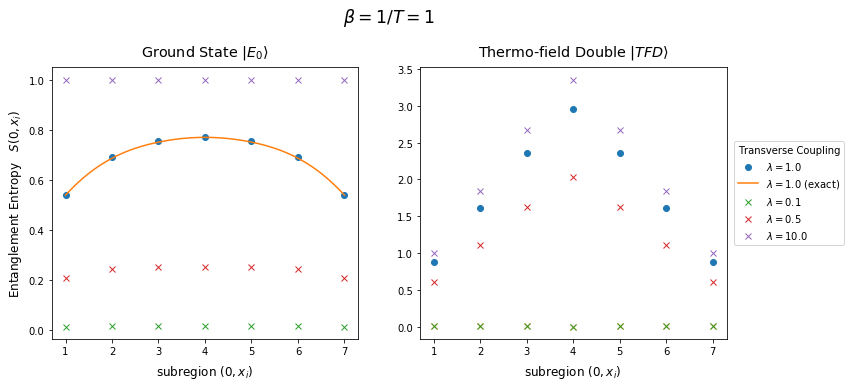

In [97]:
cols = [r'Ground State $| E_0 \rangle$', 
        r'Thermo-field Double $| TFD \rangle$']
rows = ['Exact']

clabels = [r'subregion $(0, x_i)$']*len(cols)
rlabels = [r'Entanglement Entropy   $S(0, x_i)$']*len(rows)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(12.5, 5))

#plt.setp(axes.flat, xlabel=r'$\langle Z \rangle$', ylabel='t')

pad = 5 # in points

l8 = np.linspace(1,7, 7)
Struth = np.array([S_crit(0.5, 8, x, 0.5447) for x in l8])

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.025), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline');
    
for ax, clabel in zip(axes, clabels):
    ax.annotate(clabel, xy=(0.5, -0.15), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline');

axes[0].annotate(rlabels[0], xy=(0., 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=axes[0].yaxis.label, textcoords='offset points',
                size='large', ha='center', va='center', rotation=90);

for j, cell in enumerate(axes):
    if j==0:
        leg1 = cell.plot(l8, S8plot_l010.reshape(8,)[1:], "o")
        l_smooth = np.linspace(l8.min(),l8.max(),300) #300 represents number of points to make between T.min and T.max
        spl = make_interp_spline(l8, Struth, k=3) #BSpline object
        S_smooth = spl(l_smooth)
        leg2 = cell.plot(l_smooth,S_smooth)
        
        leg3 = cell.plot(l8, S8plot_l001.reshape(8,)[1:], "x")
        leg4 = cell.plot(l8, S8plot_l005.reshape(8,)[1:], "x")
        leg5 = cell.plot(l8, S8plot_l100.reshape(8,)[1:], "x")
        
        
    if j==1:
        cell.plot(l8, S8plotTFD_l010b.reshape(8,)[1:], "o")
        cell.plot(l8, S8plotTFD_l001b.reshape(8,)[1:], "x")
        cell.plot(l8, S8plotTFD_l001b.reshape(8,)[1:], "x")
        cell.plot(l8, S8plotTFD_l005b.reshape(8,)[1:], "x")
        cell.plot(l8, S8plotTFD_l100b.reshape(8,)[1:], "x")

line_labels = [r"$\lambda = 1.0$", r"$\lambda = 1.0$ (exact)", 
               r"$\lambda = 0.1$", r"$\lambda = 0.5$", 
               r"$\lambda = 10.0$"]
        
fig.legend([leg1, leg2, leg3, leg4, leg5],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Transverse Coupling"  # Title for the legend
           )
fig.text(0.5, 1.005, r'$\beta = 1/T = 1$', ha='center', size='xx-large')
plt.subplots_adjust(right=0.875)

### Plots II

In [22]:
rhoX1_E4_RG = reduce(np.dot, [U_Bog4.getH(),
                               pTraceM(reduce(np.dot, 
                                              [U_Bog8, 
                                               np.dot(psiX1_E8, psiX1_E8.getH()),
                                               U_Bog8.getH()]
                                             ), [1,2,6,7] ),
                               U_Bog4] )

rhoX2_E4_RG = reduce(np.dot, [U_Bog4.getH(),
                               pTraceM(reduce(np.dot, 
                                              [U_Bog8, 
                                               np.dot(psiX2_E8, psiX2_E8.getH()),
                                               U_Bog8.getH()]
                                             ), [1,2,6,7] ),
                               U_Bog4] )

rhoX3_E4_RG = reduce(np.dot, [U_Bog4.getH(),
                               pTraceM(reduce(np.dot, 
                                              [U_Bog8, 
                                               np.dot(psiX3_E8, psiX3_E8.getH()),
                                               U_Bog8.getH()]
                                             ), [1,2,6,7] ),
                               U_Bog4] )

rhoX4_E4_RG = reduce(np.dot, [U_Bog4.getH(),
                               pTraceM(reduce(np.dot, 
                                              [U_Bog8, 
                                               np.dot(psiX4_E8, psiX4_E8.getH()),
                                               U_Bog8.getH()]
                                             ), [1,2,6,7] ),
                               U_Bog4] )

rhoX5_E4_RG = reduce(np.dot, [U_Bog4.getH(),
                               pTraceM(reduce(np.dot, 
                                              [U_Bog8, 
                                               np.dot(psiX5_E8, psiX5_E8.getH()),
                                               U_Bog8.getH()]
                                             ), [1,2,6,7] ),
                               U_Bog4] )

rhoX6_E4_RG = reduce(np.dot, [U_Bog4.getH(),
                               pTraceM(reduce(np.dot, 
                                              [U_Bog8, 
                                               np.dot(psiX6_E8, psiX6_E8.getH()),
                                               U_Bog8.getH()]
                                             ), [1,2,6,7] ),
                               U_Bog4] )

rhoX7_E4_RG = reduce(np.dot, [U_Bog4.getH(),
                               pTraceM(reduce(np.dot, 
                                              [U_Bog8, 
                                               np.dot(psiX7_E8, psiX7_E8.getH()),
                                               U_Bog8.getH()]
                                             ), [1,2,6,7] ),
                               U_Bog4] )

rhoX8_E4_RG = reduce(np.dot, [U_Bog4.getH(),
                               pTraceM(reduce(np.dot, 
                                              [U_Bog8, 
                                               np.dot(psiX8_E8, psiX8_E8.getH()),
                                               U_Bog8.getH()]
                                             ), [1,2,6,7] ),
                               U_Bog4] )

rhoX_E4_RG = [rhoX1_E4_RG, rhoX2_E4_RG, rhoX3_E4_RG, rhoX4_E4_RG,
              rhoX5_E4_RG, rhoX6_E4_RG, rhoX7_E4_RG, rhoX8_E4_RG]

/home/q1park/qcircuits/functions.py:227: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[itp, ix] = expval.astype(float)


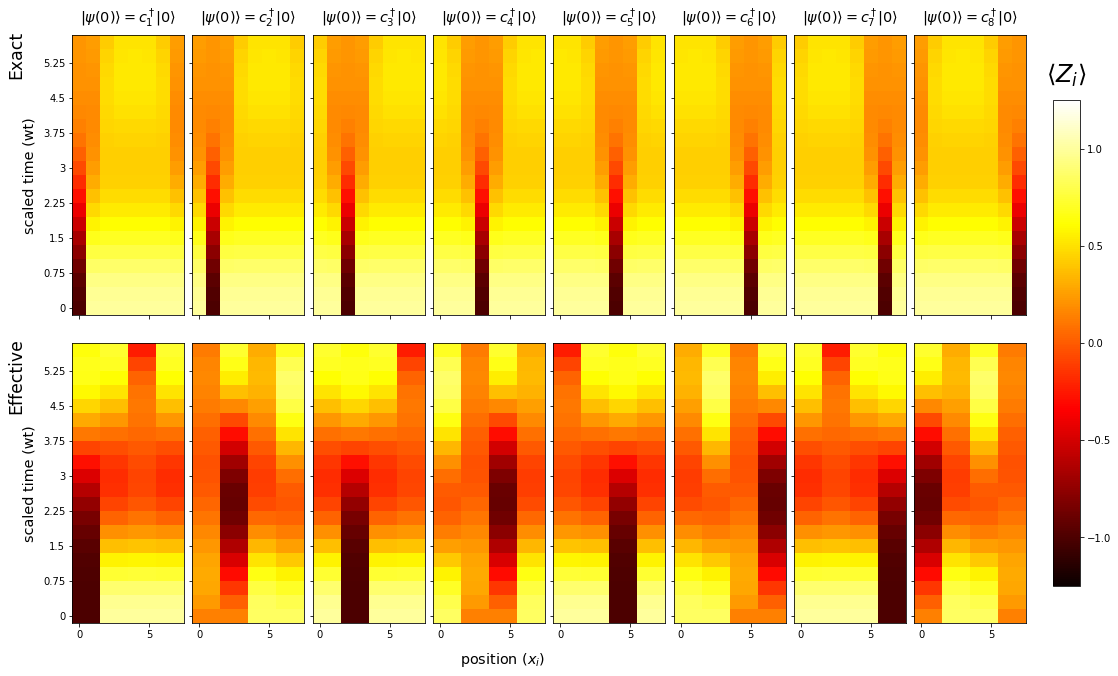

In [25]:
#cols = [r'$\langle Z \rangle = $ {}'.format(col) for col in range(8)]
#rows = ['n = {}'.format(row) for row in ['8  ', '4  ']]
cols = [r'$|\psi (0) \rangle = c_1^\dagger |0 \rangle$', r'$|\psi (0) \rangle = c_2^\dagger |0 \rangle$', 
        r'$|\psi (0) \rangle = c_3^\dagger |0 \rangle$', r'$|\psi (0) \rangle = c_4^\dagger |0 \rangle$',
        r'$|\psi (0) \rangle = c_5^\dagger |0 \rangle$', r'$|\psi (0) \rangle = c_6^\dagger |0 \rangle$',
        r'$|\psi (0) \rangle = c_7^\dagger |0 \rangle$', r'$|\psi (0) \rangle = c_8^\dagger |0 \rangle$']
rows = ['Exact', 'Effective']

clabels = ['position (x)']*len(cols)
rlabels = ['scaled time (wt)']*len(rows)

fig, axes = plt.subplots(nrows=2, ncols=8, sharex=True, sharey=True, figsize=(15, 9))

#plt.setp(axes.flat, xlabel=r'$\langle Z \rangle$', ylabel='t')

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1.025), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', fontweight = 'bold', ha='center', va='baseline');

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(-0.5, 1.), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='top', rotation=90);


for ax, rlabel in zip(axes[:,0], rlabels):
    ax.annotate(rlabel, xy=(0., 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='center', va='center', rotation=90);

for i, row in enumerate(axes):
    for j, cell in enumerate(row):
        if i==0:
            cell.imshow(scansig_time(UD_E8, psiX_E8[j], U_Dis8, [Z] ), 
                        cmap='hot', interpolation='nearest', vmin = -1.25, vmax = 1.25)
        if i==1:
            cell.imshow(-1+2*scansig_time(UD_E4, rhoX_E4_RG[j], U_Dis4, [Z], wider=True ), 
                        cmap='hot', interpolation='nearest', vmin = -1.25, vmax = 1.25)
            legender = cell.imshow(-1+2*scansig_time(UD_E4, rhoX_E4_RG[j], U_Dis4, [Z], wider=True ), 
                        cmap='hot', interpolation='nearest', vmin = -1.25, vmax = 1.25 )

plt.gca().invert_yaxis()

fig.tight_layout();
fig.subplots_adjust(wspace=0.04, hspace=0.1, top=0.95, left=0.1);
#fig.subplots_adjust(left=0.15, top=0.95);
#fig.colorbar(legender, ax=axes.ravel().tolist())
fig.text(0.5, -0.02, r'position $(x_i)$', ha='center', size='x-large')
cbar_ax = fig.add_axes([1.01, 0.1, 0.025, 0.75])
cbar = fig.colorbar(legender, cax=cbar_ax)
cbar.set_label(r'$\langle Z_i \rangle$', rotation=0, size=24, labelpad=-45, y=1.08)

labels=axes[0,0].get_yticks().tolist()
labels[1]='0'
labels[2]='0.75'
labels[3]='1.5'
labels[4]='2.25'
labels[5]='3'
labels[6]='3.75'
labels[7]='4.5'
labels[8]='5.25'
axes[0,0].set_yticklabels(labels)

plt.show();

### Plots 3

In [22]:
xplot = scanent_temp(betas, rw4, U_Dis8, 'double' ) 

/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:829: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
/home/q1park/qcircuits/functions.py:320: ComplexWarning: Casting complex values to real discards the imaginary part
  scanout[ib, ix] = entval.astype(float)
/home/q1park/anaconda3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:838: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


In [23]:
xplot = np.flip(xplot, 0)

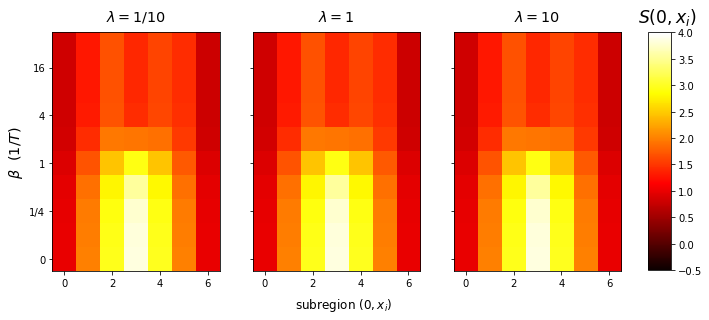

In [25]:
cols = [r'$\lambda = 1/10$', r'$\lambda = 1$', r'$\lambda = 10$']
rows = ['Exact']

clabels = ['position (x)']*len(cols)
rlabels = [r'$\beta$  $(1/T)$']*len(rows)

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(9, 5))

pad = 5 # in points


for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1.025), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline');

axes[0].annotate(rlabels[0], xy=(0., 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=axes[0].yaxis.label, textcoords='offset points',
                size='x-large', ha='center', va='center', rotation=90);
    
for j, cell in enumerate(axes):
    cell.imshow(xplot, 
                cmap='hot', interpolation='nearest', vmin = -0.5, vmax = 4.)
    legender = cell.imshow(xplot[:,1:], 
                           cmap='hot', interpolation='nearest', vmin = -0.5, vmax = 4.)


plt.gca().invert_yaxis()

fig.tight_layout();
fig.subplots_adjust(wspace=0.2, hspace=0.1, top=0.95, left=0.1);

fig.text(0.55, 0.055, r'subregion $(0, x_i)$', ha='center', size='large')
cbar_ax = fig.add_axes([1.02, 0.16, 0.035, 0.66])
cbar = fig.colorbar(legender, cax=cbar_ax)

cbar.set_label(r'$S(0,x_i)$', rotation=0, size='xx-large', labelpad=-35, y=1.11)

labels=axes[0].get_yticks().tolist()
labels[1]='0'
labels[2]='1/4'
labels[3]='1'
labels[4]='4'
labels[5]='16'
axes[0].set_yticklabels(labels)

plt.show();

In [ ]:
xplot = scanent_temp(betas, rw8, U_Dis8, 'single' ) 
plt.imshow(xplot.astype(float), cmap='hot', interpolation='nearest', vmin = -0.1, vmax = 1.,
           aspect = 0.3*4)
plt.show();

np.around(xplot, 3)

xplot = scanent_temp(betas, rw8, U_Dis8, 'mixed' ) 
plt.imshow(xplot.astype(float), cmap='hot', interpolation='nearest', vmin = -50, vmax = 50,
           aspect = 0.3*4)
plt.show();

np.around(xplot, 3)

### n=16 Circuit

In [ ]:
[0,8,-6,6,-4,4,-2,2,-7,7,-5,5,-3,3,-1,1]